### Time series model

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
df = pd.read_csv("./data/ts_processed.csv",parse_dates=[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 674116 entries, 0 to 674115
Data columns (total 5 columns):
drp_dtm         674116 non-null datetime64[ns]
drp_yyyymmdd    674116 non-null int64
drp_hrmi        674116 non-null float64
drp_loc         674116 non-null object
trips_count     674116 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 25.7+ MB


### ARIMA 

We first choose one location and try fitting using ARIMA

In [4]:
fdf = df[df['drp_loc'] == '-73.99_40.75']

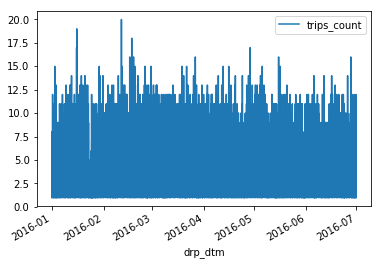

In [5]:
fdf.plot(x='drp_dtm',y='trips_count')

#### We see that the time series is more or less stationary. Hence there is no differencing needed 

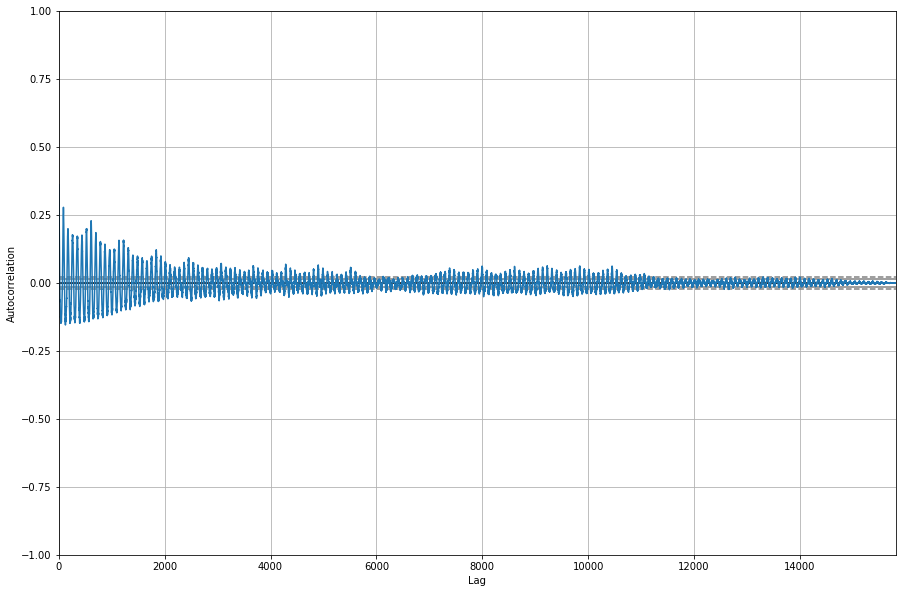

In [6]:
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(15,10))
autocorrelation_plot(fdf['trips_count'])

#### From above plot we see that  autocorrelation is non zero for time lags about 100. So we can start with AR parameter as 100

In [7]:
X = df[df['drp_loc'] == '-73.99_40.75']['trips_count'].values
X

array([1, 5, 6, ..., 5, 4, 1])

#### Before doing a train test split, we first do a fit with whole series

In [8]:
#m = ARIMA(X, order=(100,0,0))
#mf = m.fit(disp=0) #disp=0 is to turn off debug messages

#### As doing the fit for entire six months take long time, we try to use one week data

In [9]:
#sr = pd.Series(data = df[df['drp_loc'] == '-73.99_40.75']['trips_count'].values, 
#            index = df[df['drp_loc'] == '-73.99_40.75']['drp_dtm'])
fdf = df[df['drp_loc'] == '-73.99_40.75'] 

In [10]:
fdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15811 entries, 13 to 674100
Data columns (total 5 columns):
drp_dtm         15811 non-null datetime64[ns]
drp_yyyymmdd    15811 non-null int64
drp_hrmi        15811 non-null float64
drp_loc         15811 non-null object
trips_count     15811 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 741.1+ KB


In [11]:
tfdf = fdf[(fdf['drp_yyyymmdd'] >= 20160101) & (fdf['drp_yyyymmdd'] < 20160108)]

In [12]:
tfdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 587 entries, 13 to 23996
Data columns (total 5 columns):
drp_dtm         587 non-null datetime64[ns]
drp_yyyymmdd    587 non-null int64
drp_hrmi        587 non-null float64
drp_loc         587 non-null object
trips_count     587 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 27.5+ KB


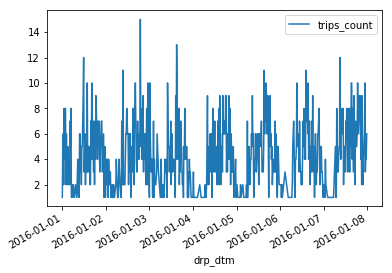

In [13]:
tfdf.plot(x='drp_dtm',y='trips_count')

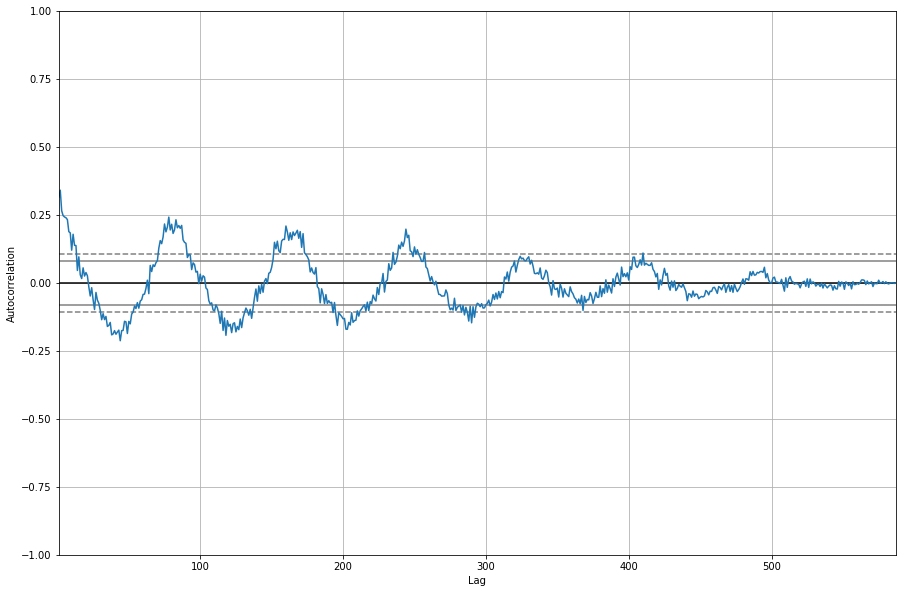

In [14]:
plt.figure(figsize=(15,10))
autocorrelation_plot(tfdf['trips_count'])

In [15]:
X = tfdf['trips_count'].values
len(X)

587

In [16]:
m = ARIMA(X, order=(10,0,0))
mf = m.fit(disp=0) #disp=0 is to turn off debug messages

In [17]:
print(mf.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  587
Model:                    ARMA(10, 0)   Log Likelihood               -1313.303
Method:                       css-mle   S.D. of innovations              2.266
Date:                Thu, 18 Oct 2018   AIC                           2650.605
Time:                        13:35:29   BIC                           2703.106
Sample:                             0   HQIC                          2671.063
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3173      0.294     14.680      0.000       3.741       4.894
ar.L1.y        0.1651      0.041      3.995      0.000       0.084       0.246
ar.L2.y        0.1951      0.042      4.662      0.0

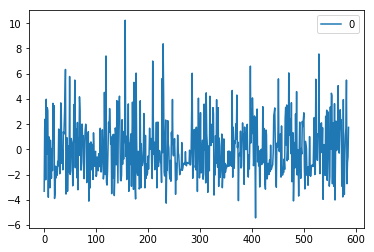

In [18]:
# Plot of residuals
pd.DataFrame(mf.resid).plot()

#### Now we create training and test sets and predict

In [19]:
#### We get a train set of first 75% of the data
train_size = int(len(X)*0.75)
train, test = X[0:train_size], X[train_size:len(X)]
print(len(train))
print(len(test))

440
147


In [20]:
h = [t for t in train]
m = ARIMA(h, order=(10,0,0))
mf = m.fit(disp=0) #disp=0 is to turn off debug messages
mf.forecast()

(array([2.12001385]), array([2.23313121]), array([[-2.2568429,  6.4968706]]))

In [21]:
# Create train set as list so as to append in the for loop
h = [t for t in train]
yhats = list() # List to store predictions
for r in range(len(test)):
    m = ARIMA(h, order=(10,0,0))
    mf = m.fit(disp=0) #disp=0 is to turn off debug messages
    fc = mf.forecast() # forecast 1 step at the end of sample returns a tuple of forecast, stderr, conf_int
    yhat = fc[0] # forecast
    yhats.append(yhat)
    actual = test[r]
    #print ('Predicted:',yhat,' Actual:', actual)
    # Append the actual to the end of list for next cycle of fit
    h.append(actual)
print ('RMSE:', np.sqrt(mean_squared_error(test, yhats)))    
    

RMSE: 2.387200150081822


In [22]:
y_null = np.zeros_like(test, dtype=float)
y_null.fill(train.mean())
y_null
print ('NULL RMSE that just predicts the training mean:', np.sqrt(mean_squared_error(test, y_null)))    

NULL RMSE that just predicts the training mean: 2.639265537661475


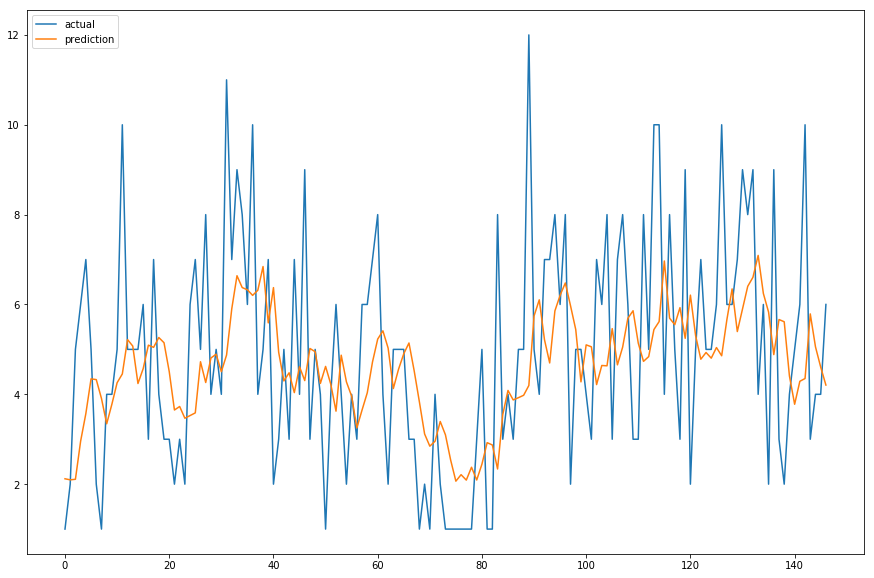

In [23]:
# Plot predictions vs actual 
plt.figure(figsize=(15,10))
plt.plot(test,label='actual')
plt.plot(yhats,label='prediction')
plt.legend(loc='upper left')

#### We can see that there is scope of further tuning of ARIMA parameters p,d,q

In [24]:
# Create a function that accepts the ARIMA parameters and prints the prediciton chart
def predict_using_ARIMA(data, train_to_test_ratio, arima_params):
    # Create train and test data
    train_size = int(len(data)*train_to_test_ratio)
    train, test = data[0:train_size], data[train_size:len(data)]
    
    # Fit and forecast using ARIMA with given params
    # Create train set as list so as to append in the for loop
    h = [t for t in train]
    yhats = list() # List to store predictions
    for r in range(len(test)):
        m = ARIMA(h, order=arima_params)
        mf = m.fit(disp=0) #disp=0 is to turn off debug messages
        fc = mf.forecast() # forecast 1 step at the end of sample returns a tuple of forecast, stderr, conf_int
        yhat = fc[0] # forecast
        yhats.append(yhat)
        actual = test[r]
        #print ('Predicted:',yhat,' Actual:', actual)
        # Append the actual to the end of list for next cycle of fit
        h.append(actual)
    print ('ARIMA params:', arima_params)
    print ('RMSE:', np.sqrt(mean_squared_error(test, yhats)))    
    y_null = np.zeros_like(test, dtype=float)
    y_null.fill(train.mean())
    print ('NULL RMSE that just predicts the training mean:', np.sqrt(mean_squared_error(test, y_null)))  
    # Plot 
    plt.figure(figsize=(15,10))
    plt.plot(test,label='actual')
    plt.plot(yhats,label='prediction')
    plt.legend(loc='upper left')
    plt.show()

ARIMA params: (10, 0, 0)
RMSE: 2.387200150081822
NULL RMSE that just predicts the training mean: 2.639265537661475


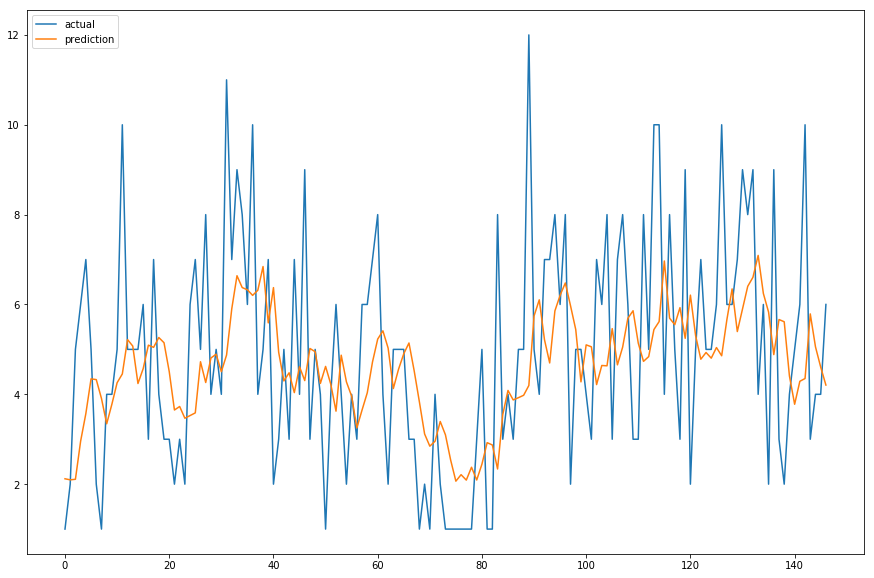

In [25]:
predict_using_ARIMA(tfdf['trips_count'].values, 0.75, (10,0,0))

ARIMA params: (10, 1, 0)
RMSE: 2.470615186069691
NULL RMSE that just predicts the training mean: 2.639265537661475


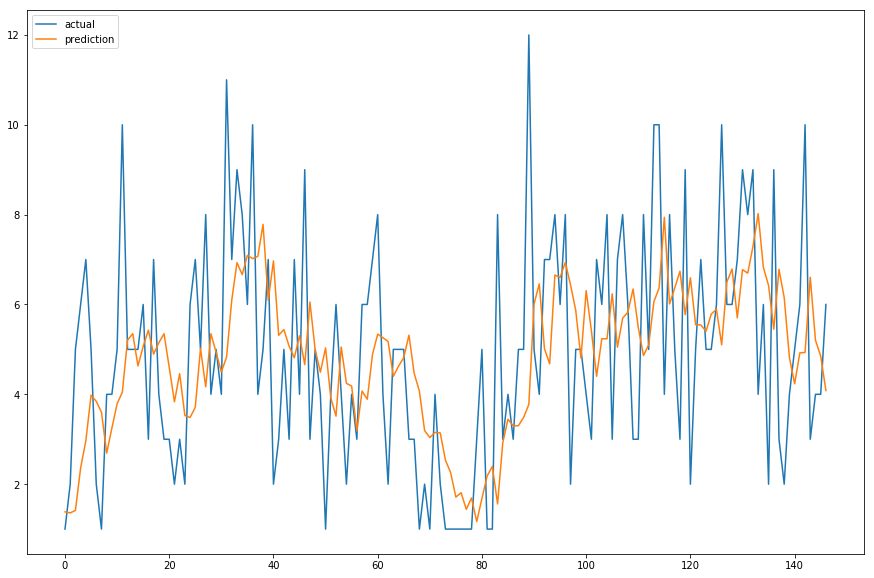

In [26]:
predict_using_ARIMA(tfdf['trips_count'].values, 0.75, (10,1,0))

ARIMA params: (10, 1, 1)
RMSE: 2.466934970871484
NULL RMSE that just predicts the training mean: 2.639265537661475


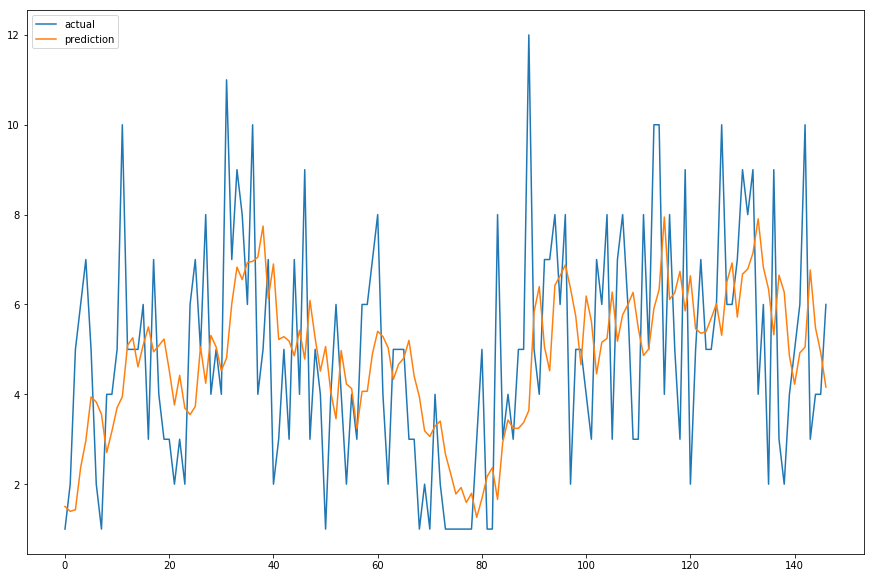

In [27]:
predict_using_ARIMA(tfdf['trips_count'].values, 0.75, (10,1,1))

ARIMA params: (5, 0, 0)
RMSE: 2.375083082578837
NULL RMSE that just predicts the training mean: 2.639265537661475


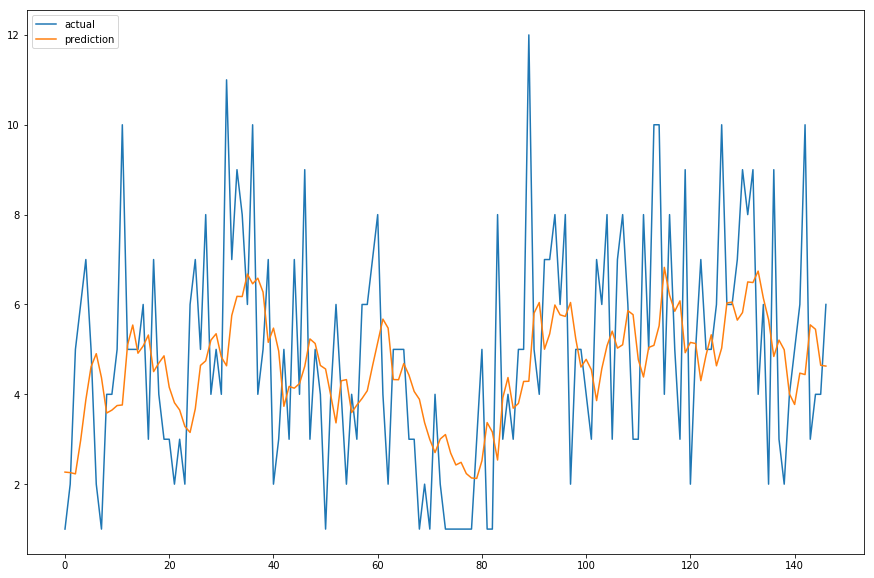

In [28]:
predict_using_ARIMA(tfdf['trips_count'].values, 0.75, (5,0,0))

#### We see that ARIMA with AR=5, differencing 0 and Moving Average 0 gives us low RMSE

## Facebook's prophet

In [29]:
from fbprophet import Prophet

In [30]:
tfdf.head()

,drp_dtm,drp_yyyymmdd,drp_hrmi,drp_loc,trips_count
13,2016-01-01 00:00:00,20160101,0.00,-73.99_40.75,1
63,2016-01-01 00:15:00,20160101,0.25,-73.99_40.75,5
117,2016-01-01 00:30:00,20160101,0.50,-73.99_40.75,6
180,2016-01-01 00:45:00,20160101,0.75,-73.99_40.75,2
251,2016-01-01 01:00:00,20160101,1.00,-73.99_40.75,8


In [31]:
pf = tfdf[['drp_dtm','trips_count']]

In [32]:
pf = pf.rename({'drp_dtm':'ds', 'trips_count':'y'},axis=1)

In [33]:
m = Prophet()

In [34]:
m.fit(pf)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [35]:
future = fdf[(fdf['drp_yyyymmdd'] >= 20160108) & (fdf['drp_yyyymmdd'] < 20160115)][['drp_dtm','trips_count']].rename({'drp_dtm':'ds'},axis=1)

In [36]:
future.tail()

,ds,trips_count
48939,2016-01-14 22:45:00,7
48995,2016-01-14 23:00:00,6
49043,2016-01-14 23:15:00,1
49093,2016-01-14 23:30:00,4
49142,2016-01-14 23:45:00,2


In [37]:
forecast = m.predict(future)

In [38]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
602,2016-01-14 22:45:00,6.125273,2.914398,8.663347,5.512841,6.773058,-0.341594,-0.341594,-0.341594,-0.341594,-0.341594,-0.341594,0.0,0.0,0.0,5.783680
603,2016-01-14 23:00:00,6.127618,2.787445,8.369134,5.513847,6.777250,-0.515164,-0.515164,-0.515164,-0.515164,-0.515164,-0.515164,0.0,0.0,0.0,5.612454
604,2016-01-14 23:15:00,6.129962,2.325227,8.357989,5.514814,6.781442,-0.681876,-0.681876,-0.681876,-0.681876,-0.681876,-0.681876,0.0,0.0,0.0,5.448086
605,2016-01-14 23:30:00,6.132306,2.509531,8.432658,5.515759,6.785634,-0.837168,-0.837168,-0.837168,-0.837168,-0.837168,-0.837168,0.0,0.0,0.0,5.295138
606,2016-01-14 23:45:00,6.134650,2.402610,8.191214,5.516695,6.789826,-0.977115,-0.977115,-0.977115,-0.977115,-0.977115,-0.977115,0.0,0.0,0.0,5.157536


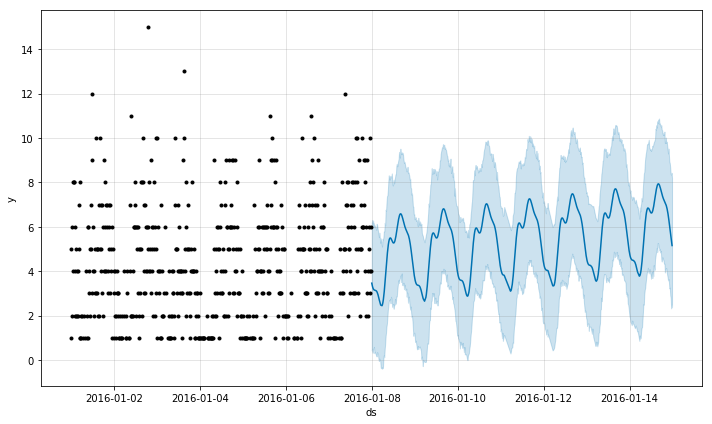

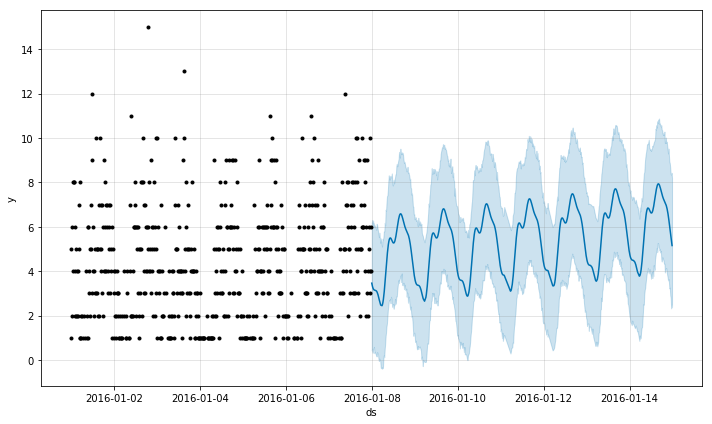

In [39]:
m.plot(forecast)

In [40]:
future.head()

,ds,trips_count
24051,2016-01-08 00:00:00,3
24097,2016-01-08 00:15:00,2
24140,2016-01-08 00:30:00,4
24177,2016-01-08 00:45:00,1
24207,2016-01-08 01:00:00,2


In [41]:
forecast.count()

ds                            607
trend                         607
yhat_lower                    607
yhat_upper                    607
trend_lower                   607
trend_upper                   607
additive_terms                607
additive_terms_lower          607
additive_terms_upper          607
daily                         607
daily_lower                   607
daily_upper                   607
multiplicative_terms          607
multiplicative_terms_lower    607
multiplicative_terms_upper    607
yhat                          607
dtype: int64

In [42]:
future.count()

ds             607
trips_count    607
dtype: int64

In [43]:
np.sqrt(mean_squared_error(future.trips_count.values, forecast.yhat.values))

2.5219140389035175

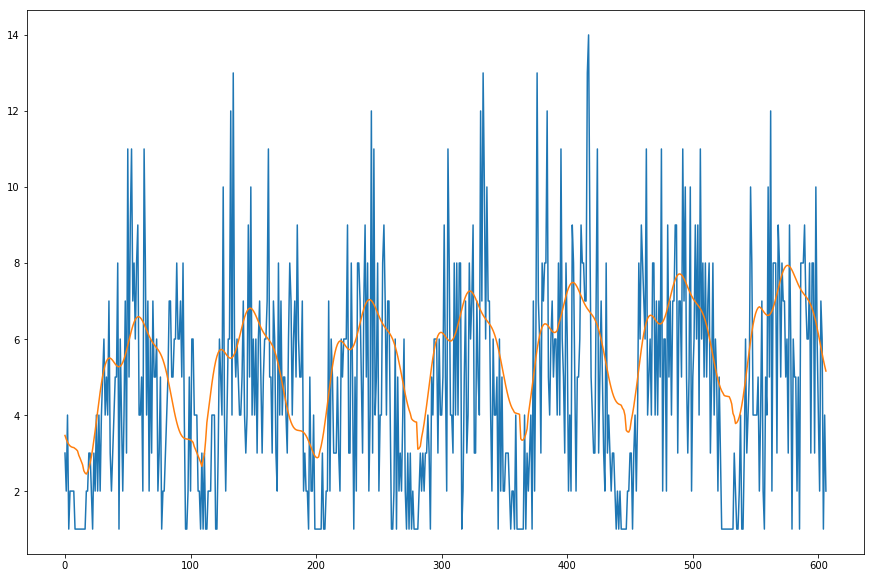

In [44]:
plt.figure(figsize=(15,10))
plt.plot(future.trips_count.values, label='actual')
plt.plot(forecast.yhat.values, label='predicted')


#### We see that both ARIMA and Prophet more or less predict with same RMSE. But performance wise the Prophet model takes less time to fit.

In [83]:
# Create a function prints the prediciton chart using Prophet prediction model
def predict_using_Prophet(data, train_to_test_ratio, remarks):
    
    # Create dataframe and rename columns as needed by Prophet
    pf = data[['drp_dtm','trips_count']]
    pf = pf.rename({'drp_dtm':'ds', 'trips_count':'y'},axis=1)
    
    # Create train and test data
    train_size = int(len(data)*train_to_test_ratio)
    train_df, test_df = pf.iloc[0:train_size], pf.iloc[train_size:len(data)]
    
    #print(train_df.head())
    #print(test_df.head())
    
    
    
    # Fit and forecast using Prophet 
    m = Prophet()
    m.fit(train_df)
    
    
    forecast = m.predict(test_df)
    #print(forecast)
    #m.plot(forecast)
    
    #print (test_df)
    #print (test_df['y'].values)
    #print (forecast['yhat'].values)
    #return
    print (remarks)
    print ('RMSE:', np.sqrt(mean_squared_error(test_df['y'].values, forecast['yhat'].values)))    
    y_null = np.zeros_like(test_df['y'].values, dtype=float)
    y_null.fill(train_df['y'].values.mean())
    print ('NULL RMSE that just predicts the training mean:', np.sqrt(mean_squared_error(test_df['y'].values, y_null)))  
    # Plot 
    plt.figure(figsize=(15,10))
    plt.plot(test_df['y'].values,label='actual')
    plt.plot(forecast['yhat'].values,label='prediction')
    plt.legend(loc='upper left')
    plt.show()

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Prophet prediction
RMSE: 2.5368512046510827
NULL RMSE that just predicts the training mean: 2.639265537661475


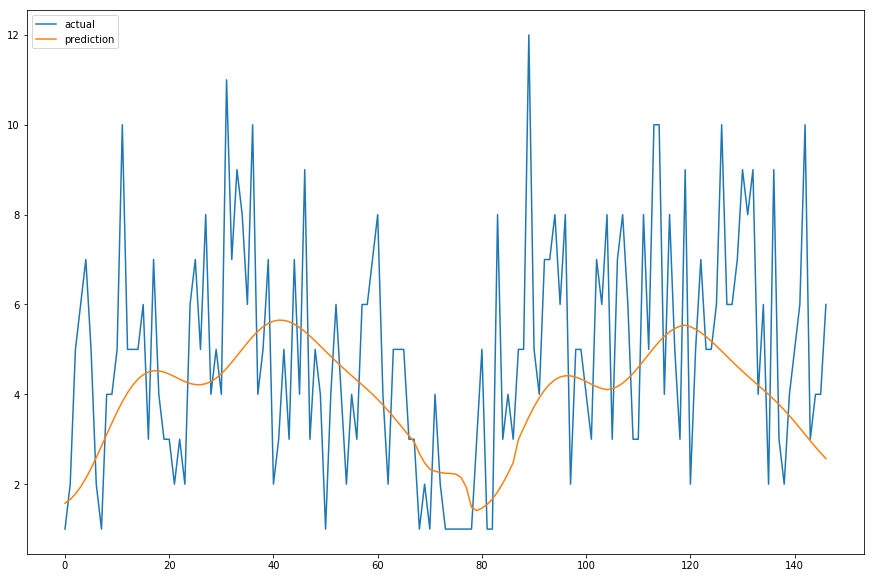

In [84]:
predict_using_Prophet(tfdf,0.75,'Prophet prediction')

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 674116 entries, 0 to 674115
Data columns (total 5 columns):
drp_dtm         674116 non-null datetime64[ns]
drp_yyyymmdd    674116 non-null int64
drp_hrmi        674116 non-null float64
drp_loc         674116 non-null object
trips_count     674116 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 25.7+ MB


In [82]:
df.trips_count.value_counts()

1     369740
2     121829
3      68696
4      42664
5      26826
6      17253
7      10732
8       6453
9       3995
10      2386
11      1434
12       824
13       490
14       314
15       195
16       109
17        77
18        46
19        27
20        13
21         6
22         4
23         2
24         1
Name: trips_count, dtype: int64

In [85]:
# Create a function prints the prediciton chart using Prophet prediction model
def predict_using_Prophet_logistic(data, train_to_test_ratio, remarks):
    
    # Create dataframe and rename columns as needed by Prophet
    pf = data[['drp_dtm','trips_count']]
    pf = pf.rename({'drp_dtm':'ds', 'trips_count':'y'},axis=1)
    pf['cap'] = 25 # We set 25 as the maximum number of trips possible in that time slot in that location
    
    # Create train and test data
    train_size = int(len(data)*train_to_test_ratio)
    train_df, test_df = pf.iloc[0:train_size], pf.iloc[train_size:len(data)]
    
    #print(train_df.head())
    #print(test_df.head())
    
    
    
    # Fit and forecast using Prophet 
    m = Prophet(growth='logistic')
    m.fit(train_df)
    
    
    forecast = m.predict(test_df)
    #print(forecast)
    #m.plot(forecast)
    
    #print (test_df)
    #print (test_df['y'].values)
    #print (forecast['yhat'].values)
    #return

    print (remarks)
    print ('RMSE:', np.sqrt(mean_squared_error(test_df['y'].values, forecast['yhat'].values)))    
    y_null = np.zeros_like(test_df['y'].values, dtype=float)
    y_null.fill(train_df['y'].values.mean())
    print ('NULL RMSE that just predicts the training mean:', np.sqrt(mean_squared_error(test_df['y'].values, y_null)))  
    # Plot 
    plt.figure(figsize=(15,10))
    plt.plot(test_df['y'].values,label='actual')
    plt.plot(forecast['yhat'].values,label='prediction')
    plt.legend(loc='upper left')
    plt.show()


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Prophet logistic prediction
RMSE: 2.3931045270710403
NULL RMSE that just predicts the training mean: 2.639265537661475


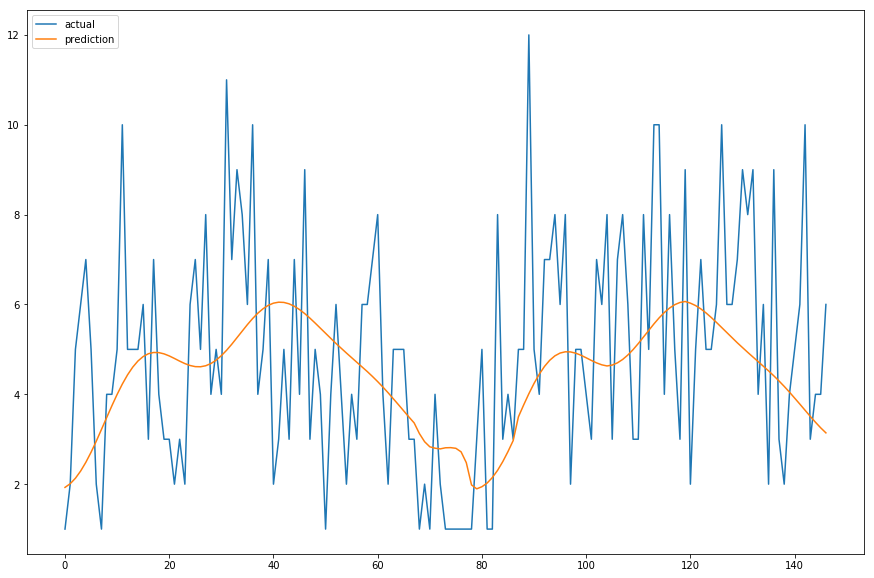

In [86]:
predict_using_Prophet_logistic(tfdf,0.75,'Prophet logistic prediction')

In [1]:
df.head()

NameError: name 'df' is not defined